In [1]:
import pandas as pd
import numpy as np

from collections import deque

import utils as u

import pickle
import time

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from scipy.stats import entropy

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline

# vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# feature selectors
from sklearn.feature_selection import SelectKBest, chi2

# scalers
from sklearn.preprocessing import MinMaxScaler

# classifiers
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression

# samplers
from imblearn.under_sampling import TomekLinks

# calibration
from sklearn.calibration import CalibratedClassifierCV

In [2]:
df = pd.read_pickle('../pandas/lemma_delivered_merged_df.pkl')

In [3]:
#df['ft'] = pd.read_pickle('../pandas/FT_TFIDF_lemma_labeled_vocab.pkl')
df['ft'] = pd.read_pickle('../pandas/FT_TFIDF_lemma_full_vocab.pkl')
df['is_nn'] = pd.read_pickle('../pandas/is_nn_full.pkl')
df['is_trash'] = pd.read_pickle('../pandas/is_trash_full.pkl')

In [4]:
labeled_corpus = df[(df['agg_label'] != -1) & (df['is_nn'] == False)]
unlabeled_corpus = df[(df['agg_label'] == -1) & (df['is_nn'] == False) & (df['is_trash'] == False)]

target = 'agg_label'
text = 'lemma_delivered'
fasttext = 'ft'
numeric = ['raw_len', 'raw_word_count']

In [5]:
train_X, vali_X, train_y, vali_y = train_test_split(
    labeled_corpus,
    labeled_corpus[target],
    test_size=0.4,
    random_state=1,
    stratify=labeled_corpus[target])

test_X, validation_X, test_y, validation_y = train_test_split(
    vali_X,
    vali_y,
    test_size=0.5,
    random_state=1,
    stratify=vali_y)

In [6]:
# models
clf_LinearSVC = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01})
baseline_model = {
    'title': 'baseline_model',
    'features': ('Text+FT', {'text': text, 'ft': fasttext}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('MinMaxScaler', MinMaxScaler, {'feature_range': (0,1)}),
    'sampler': ('TomekLinks', TomekLinks, {'random_state': 1, 'sampling_strategy': 'majority', 'n_jobs': -1}),
    #'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LinearSVC', CalibratedClassifierCV, {'base_estimator': clf_LinearSVC, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

quick_svm_model = {
    'title': 'quick_svm_model',
    'features': ('Text+FT', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

clf_ComplementNB = ComplementNB(**{'alpha': 0.2})
quick_model = {
    'title': 'quick_model',
    'features': ('TextOnly', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_ComplementNB', CalibratedClassifierCV, {'base_estimator': clf_ComplementNB, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('CalibratedClassifierCV_ComplementNB', CalibratedClassifierCV, {'base_estimator': clf_ComplementNB, 'cv': 3}),
}

clf_LogisticRegression = LogisticRegression(**{'solver': 'saga', 'tol': 0.0001, 'C': 8, 'n_jobs': -1, 'random_state': 1})
log_model = {
    'title': 'log_model',
    'features': ('TextOnly', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LogisticRegression', CalibratedClassifierCV, {'base_estimator': clf_LogisticRegression, 'method': 'isotonic', 'cv': 3}),
}

wordembed_model = {
    'title': 'wordembed_model',
    'features': ('FT', {'ft': fasttext}),
    'vectorizer': ('TfidfVectorizer', u.PassThrough, {}),
    'scaler': ('MinMaxScaler', MinMaxScaler, {'feature_range': (0,1)}),
    #'sampler': ('TomekLinks', TomekLinks, {'random_state': 1, 'sampling_strategy': 'majority', 'n_jobs': -1}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LinearSVC', CalibratedClassifierCV, {'base_estimator': clf_LinearSVC, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

In [7]:
class FastTextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        return np.stack(df[self.col].to_numpy())

def modeller(data, model):

    features = []

    if 'text' in model['features'][1]:
        features.append(
            ('text', Pipeline([
                ('article', u.ColumnSelector(model['features'][1]['text'])),
                ('vectorizer', model['vectorizer'][1](**model['vectorizer'][2])),
            ]))
        )

    if 'ft' in model['features'][1]:
        features.append(
            ('embeddings', Pipeline([
                ('ft', FastTextSelector(model['features'][1]['ft'])),
                ('scaler', model['scaler'][1](**model['scaler'][2])),
            ]))
        )

    model = Pipeline([
        ('features', FeatureUnion(features)),
        ('sampler', model['sampler'][1](**model['sampler'][2])),
        ('classifier', model['classifier'][1](**model['classifier'][2]))
    ])
    

    model.fit(data['train_X'], data['train_y'])
    preds = model.predict(data['validation_X'])
    probs = model.predict_proba(data['validation_X'])
    
    metrics = {}
    
    if 'validation_y' in data:
        metrics['acc'] = accuracy_score(data['validation_y'], preds)
        metrics['prec'], metrics['reca'], metrics['fsco'], _ = precision_recall_fscore_support(data['validation_y'], preds, average='macro')
        #print(acc, prec, reca, fsco)
    
    return preds, probs, metrics

def get_entropy_train_x(t_X, t_y, scaler):
    
    train_a_X, train_b_X, train_a_y, train_b_y = train_test_split(
        t_X,
        t_y,
        test_size=0.5,
        random_state=1,
        stratify=t_y)
    
    data_a = {
        'train_X': train_a_X,
        'train_y': train_a_y,
        'validation_X': train_b_X,
        'validation_y': train_b_y
    }
    
    data_b = {
        'train_X': train_b_X,
        'train_y': train_b_y,
        'validation_X': train_a_X,
        'validation_y': train_a_y
    }
    
    preds_b, probs_b, metric_b = modeller(data_a, baseline_model)
    preds_a, probs_a, metric_a = modeller(data_b, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)
    #dynamic_thresholds_b = get_dynamic_threshold(preds_a, prob_a, scaler)
    
    print(dynamic_threshold)

    entropy_a = entropy(probs_a.T)
    entropy_b = entropy(probs_b.T)
    
    entropy_ab = np.concatenate([entropy_a, entropy_b])
    
    mean_entropy = entropy_ab.mean() + ((entropy_ab.max() - entropy_ab.mean())/2)

    mask_below_a = entropy_a <= mean_entropy
    mask_below_b = entropy_b <= mean_entropy
    
    mask_above_a = entropy_a > mean_entropy
    mask_above_b = entropy_b > mean_entropy
    
    index_below = train_a_X.loc[mask_below_a].index.union(train_b_X.loc[mask_below_b].index)
    index_above = train_a_X.loc[mask_above_a].index.union(train_b_X.loc[mask_above_b].index)

    #probs_a_sorted = np.sort(probs_a)
    #probs_b_sorted = np.sort(probs_b)
    #margin_a = 1 - (probs_a_sorted[:,-1] + probs_a_sorted[:,-2])
    #margin_b = 1 - (probs_b_sorted[:,-1] + probs_b_sorted[:,-2])
    #margin = np.concatenate([margin_a, margin_b])

    return index_below, index_above, dynamic_threshold


def get_entropy_co_trained(data, index_below, index_above, dynamic_threshold, threshold=0.9, scaler=0.93):

    data_a = {
        'train_X': data['train_X'].loc[index_below],
        'train_y': data['train_y'].loc[index_below],
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': data['train_X'].loc[index_above],
        'train_y': data['train_y'].loc[index_above],
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_a, baseline_model)
    preds_b, probs_b, _ = modeller(data_b, baseline_model)
    
    #dynamic_threshold_a = get_dynamic_threshold(preds_b, np.amax(probs_a, axis=1), scaler)
    #dynamic_threshold_b = get_dynamic_threshold(preds_b, np.amax(probs_b, axis=1), scaler)
    #print(dynamic_threshold_a)
    #print(dynamic_threshold_b)
    
    print("Mean entropy a: " + str(entropy(probs_a.T).mean()))
    print("Mean entropy b: " + str(entropy(probs_b.T).mean()))
    
    print("Mean probs a: " + str(np.amax(probs_a, axis=1).mean()) + ", Max probs a: " + str(np.amax(probs_a, axis=1).max()))
    print("Mean probs b: " + str(np.amax(probs_b, axis=1).mean()) + ", Max probs b: " + str(np.amax(probs_b, axis=1).max()))
    
    pred_mask = preds_a == preds_b
    
    print("Number of equals: " + str(pred_mask.sum()))
    
    prob_mask_a = np.amax(probs_a, axis=1) > threshold
    prob_mask_b = np.amax(probs_b, axis=1) > threshold
    
    #prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    #prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))
    
    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)
    
    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)
    
    print("Mask length: " + str(mask.sum()))
    
    return mask, preds_a

def get_dynamic_threshold(preds, probs, scaler=0.9):
    
    dynamic_thresholds = {}
    for l in np.unique(preds):
        if l in [12]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.01)
        elif l in [3]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.005)
        else:
            dynamic_thresholds[l] = probs[preds == l].max() * scaler
        
    return dynamic_thresholds

def get_dynamic_threshold_mask(preds, probs, dynamic_thresholds):
        
    mask = []
    for i in range(preds.shape[0]):
        if probs[i] >= dynamic_thresholds[preds[i]]:
            mask.append(True)
        else:
            mask.append(False)
    
    return np.array(mask)


def get_model(data, scaler=0.9):

    preds, probs, _ = modeller(data, baseline_model)

    prob = np.amax(probs, axis=1)
    
    dynamic_threshold = get_dynamic_threshold(preds, prob, scaler)
    
    mask = get_dynamic_threshold_mask(preds, prob, dynamic_threshold)
    
    return mask, preds


def random_split(data, scaler=0.9, threshold=0.9):
    
    train_a_X, train_b_X, train_a_y, train_b_y = train_test_split(
        data['train_X'],
        data['train_y'],
        test_size=0.5,
        random_state=1,
        stratify=data['train_y'])
    
    data_a = {
        'train_X': train_a_X,
        'train_y': train_a_y,
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': train_b_X,
        'train_y': train_b_y,
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_b, baseline_model)
    preds_b, probs_b, _ = modeller(data_a, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    pred_mask = preds_a == preds_b

    #prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    #prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    prob_mask_a = np.amax(probs_a, axis=1) > threshold
    prob_mask_b = np.amax(probs_b, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))

    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return mask, preds_a


def support_vector_split(data, scaler=0.9, threshold=0.9):
    
    vec = TfidfVectorizer(**{'lowercase': False, 'max_df': 0.25})
    vec_t_X = vec.fit_transform(data['train_X'][text])
    clf = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}).fit(vec_t_X, data['train_y'])
    decision_function = clf.decision_function(vec_t_X)
    support_vector_indices = np.where(np.amin(np.abs(decision_function), axis=1) <= 0.4)[0]
    not_support_vector_indices = [x for x in range(X.shape[0]) if x not in support_vector_indices]
    
    #display(data['train_y'].iloc[support_vector_indices].value_counts())
    #display(data['train_y'].iloc[not_support_vector_indices].value_counts())

    data_a = {
        'train_X': data['train_X'].iloc[support_vector_indices],
        'train_y': data['train_y'].iloc[support_vector_indices],
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': data['train_X'].iloc[not_support_vector_indices],
        'train_y': data['train_y'].iloc[not_support_vector_indices],
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_b, baseline_model)
    preds_b, probs_b, _ = modeller(data_a, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    pred_mask = preds_a == preds_b

    prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    #prob_mask_a = np.amax(probs_a, axis=1) > threshold
    #prob_mask_b = np.amax(probs_b, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))

    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return mask, preds_a



def basic_wrapper(scaler=0.9, threshold=0.9, iterations=10, sample_size=1000):

    sampled_indexes = pd.Index([])

    iter_data = [
        train_X.copy(),
        train_y.copy()
    ]

    for i in range(iterations):

        print("Iteration: " + str(i+1))

        if sample_size != False:
            sample = unlabeled_corpus.drop(labels=sampled_indexes).sample(n=sample_size, random_state=i)
        else:
            sample = unlabeled_corpus.drop(labels=sampled_indexes)
            
        data_sample = {
            'train_X': iter_data[0],
            'train_y': iter_data[1],
            'validation_X': sample
        }
            
        #index_below, index_above, dynamic_threshold = get_entropy_train_x(iter_data[0], iter_data[1], scaler)
        #mask, preds = get_entropy_co_trained(data_sample, index_below, index_above, dynamic_threshold, threshold=threshold)
        
        #mask, preds = get_model(data_sample, scaler=scaler)
        
        #mask, preds = random_split(data_sample, scaler=scaler, threshold=threshold)
        
        mask, preds = support_vector_split(data_sample, scaler=scaler, threshold=threshold)
        
        sample['preds'] = preds

        if mask.sum() > 0:
            
            iter_data[0] = pd.concat([iter_data[0], sample.drop(['preds'], axis=1).loc[mask]])
            iter_data[1] = iter_data[1].append(sample.loc[mask]['preds'])

            sampled_indexes = sampled_indexes.union(sample.loc[mask].index)

            print("Total number of unlabeled added: " + str(sampled_indexes.shape[0]))
            
        else:
            print("No new samples!")
            if sample_size == False:
                break

    
    data_test = {
        'train_X': iter_data[0],
        'train_y': iter_data[1],
        'validation_X': test_X,
        'validation_y': test_y,
    }
    
    test_preds, _, test_metrics = modeller(data_test, baseline_model)

    return sampled_indexes, iter_data, test_preds, test_metrics

In [79]:
sampled_indexes, iter_data, test_preds, test_metrics = basic_wrapper(scaler=0.9, threshold=0.88, iterations=1, sample_size=False)

Iteration: 1


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divid

{1: 0.8369189641961886, 2: 0.7887915382076031, 3: 0.8927053558058093, 4: 0.8435720604410453, 5: 0.7504150121796617, 6: 0.864015066692962, 7: 0.8622936894942709, 8: 0.8729204172981054, 9: 0.8428288871233568, 10: 0.8854412284769908, 12: 0.8817191192295348, 13: 0.828642225205863, 14: 0.8282538667370246, 15: 0.8675070960720492, 16: 0.8576265186453611, 17: 0.8788132147449055, 18: 0.6953019603057161, 19: 0.8012256974764501, 20: 0.8515226308587619, 21: 0.7451025605076336, 23: 0.8577075297327253, 24: 0.8317352727720786, 25: 0.8242531068079966, 26: 0.8237185052162804, 91: 0.7656467555841652, 92: 0.7885543771549937, 93: 0.8620138225917318}
Prob mask a: 470934
Prob mask b: 4194
Mask length: 4124
Total number of unlabeled added: 4124


In [80]:
test_metrics

{'acc': 0.7048564529111886,
 'prec': 0.7001205869661876,
 'reca': 0.6657374143847785,
 'fsco': 0.6788624415550335}

In [81]:
(iter_data[1].value_counts() - train_y.value_counts())

1      61
2      16
3     815
4     300
5      36
6     430
7      68
8     411
9      99
10    326
12    407
13     48
14     98
15     40
16    158
17    252
18     11
19     65
20    117
21     10
23    160
24      7
25    130
26     25
91     17
92      7
93     10
dtype: int64

In [ ]:
entropy_train_X = get_entropy_train_x(train_X, train_y)

data_vali = {
    'train_X': entropy_train_X,
    'train_y': entropy_train_X[target],
    'validation_X': validation_X
}

mask, preds = get_entropy_co_trained(data_vali, threshold=0.93)

In [ ]:
np.mean(validation_y[mask] == preds[mask])

In [ ]:
np.amin(np.abs(decision_function), axis=1)

In [ ]:
np.where(np.amin(np.abs(decision_function), axis=1) <= 1)[0]

In [9]:
def get_preds_probs(X, y, v_X):
    
    clf_LinearSVC = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01})
    clf_ComplementNB = ComplementNB(**{'alpha': 0.2})
    clf = CalibratedClassifierCV(**{'base_estimator': clf_LinearSVC, 'method': 'isotonic', 'cv': 3}).fit(X, y)
    preds = clf.predict(v_X)
    probs = clf.predict_proba(v_X)
    
    return preds, probs

def plot_entropy_co_train(X, y, v_X, scaler=0.9, threshold=0.9):
    
    train_a_X, train_b_X, train_a_y, train_b_y = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=1,
        stratify=y)
    

    preds_b, probs_b = get_preds_probs(train_a_X, train_a_y, train_b_X)
    preds_a, probs_a = get_preds_probs(train_b_X, train_b_y, train_a_X)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    entropy_a = entropy(probs_a.T)
    entropy_b = entropy(probs_b.T)

    entropy_ab = np.concatenate([entropy_a, entropy_b])
    
    mean_entropy = entropy_ab.mean()
    #mean_entropy = 0.6

    mask_below_a = entropy_a <= mean_entropy
    mask_below_b = entropy_b <= mean_entropy

    mask_above_a = entropy_a > mean_entropy
    mask_above_b = entropy_b > mean_entropy
    
    below_X = np.concatenate([train_a_X[mask_below_a], train_b_X[mask_below_b]])
    above_X = np.concatenate([train_a_X[mask_above_a], train_b_X[mask_above_b]])
    
    below_y = np.concatenate([train_a_y[mask_below_a], train_b_y[mask_below_b]])
    above_y = np.concatenate([train_a_y[mask_above_a], train_b_y[mask_above_b]])

    
    preds_below, probs_below = get_preds_probs(below_X, below_y, v_X)
    preds_above, probs_above = get_preds_probs(above_X, above_y, v_X)
    
    pred_mask = preds_above == preds_below

    #prob_mask_above = get_dynamic_threshold_mask(preds_above, np.amax(probs_above, axis=1), dynamic_threshold)
    #prob_mask_below = get_dynamic_threshold_mask(preds_below, np.amax(probs_below, axis=1), dynamic_threshold)
    
    prob_mask_above = np.amax(probs_above, axis=1) > threshold
    prob_mask_below = np.amax(probs_below, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_above.sum()))
    print("Prob mask b: " + str(prob_mask_below.sum()))

    prob_mask = np.all(np.array([prob_mask_above, prob_mask_below]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return below_X, above_X, below_y, above_y, mask, preds_below


def plot_random_co_train(X, y, v_X, scaler=0.9, threshold=0.9):
    
    train_a_X, train_b_X, train_a_y, train_b_y = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=1,
        stratify=y)
    

    preds_b, probs_b = get_preds_probs(train_a_X, train_a_y, v_X)
    preds_a, probs_a = get_preds_probs(train_b_X, train_b_y, v_X)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    pred_mask = preds_a == preds_b

    #prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    #prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    prob_mask_a = np.amax(probs_a, axis=1) > threshold
    prob_mask_b = np.amax(probs_b, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))

    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return preds_a, mask, train_a_X, train_b_X, train_a_y, train_b_y


def get_single_train(X, y, v_X, scaler=0.9):
    
    preds, probs = get_preds_probs(X, y, v_X)
    
    prob = np.amax(probs, axis=1)
    
    dynamic_threshold = get_dynamic_threshold(preds, prob, scaler)
    
    mask = get_dynamic_threshold_mask(preds, prob, dynamic_threshold)
    
    return preds, mask
   
    
    
def plot_support_co_train(X, y, v_X, scaler=0.9, threshold=0.9):

    clf_LinearSVC = LinearSVC(**{'C': 1, 'loss': 'squared_hinge', 'tol': 0.01, 'random_state': 1}).fit(X, y)
    decision_function = clf_LinearSVC.decision_function(X)
    support_vector_indices = np.where(np.amin(np.abs(decision_function), axis=1) <= 0.5)[0]
    not_support_vector_indices = [x for x in range(X.shape[0]) if x not in support_vector_indices]

    preds_b, probs_b = get_preds_probs(X[support_vector_indices, :], y[support_vector_indices], v_X)
    preds_a, probs_a = get_preds_probs(X[not_support_vector_indices, :], y[not_support_vector_indices], v_X)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    pred_mask = preds_a == preds_b

    #prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    #prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    prob_mask_a = np.amax(probs_a, axis=1) > threshold
    prob_mask_b = np.amax(probs_b, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))

    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return preds_a, mask, support_vector_indices, not_support_vector_indices



def support_filtered(X, y, v_X, scaler=0.9):
    
    preds, probs = get_preds_probs(X, y, v_X)
    
    prob = np.amax(probs, axis=1)
    
    
    clf = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}).fit(v_X, preds)
    decision_function = clf.decision_function(v_X)
    support_vector_indices = np.where(np.amin(np.abs(decision_function), axis=1) <= 0.2)[0]
    not_support_vector_indices = [x for x in range(v_X.shape[0]) if x not in support_vector_indices]
    
    support_mask = [True if x in support_vector_indices else False for x in range(v_X.shape[0])]

    
    dynamic_threshold = get_dynamic_threshold(preds, prob, scaler)
    
    mask = get_dynamic_threshold_mask(preds, prob, dynamic_threshold)
    
    filtered_mask = np.all(np.array([support_mask, mask]), axis=0)
    
    return preds, mask, support_vector_indices, not_support_vector_indices

    

In [10]:
X, y = make_blobs(n_samples=20000, centers=3, random_state=0, center_box=(0,20))

t_X, v_X, t_y, v_y = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=1,
        stratify=y)

In [18]:
preds, filtered_mask, support_vector_indices, not_support_vector_indices = support_filtered(t_X, t_y, v_X, scaler=0.99)
np.mean(preds[filtered_mask] == v_y[filtered_mask])

C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1.0

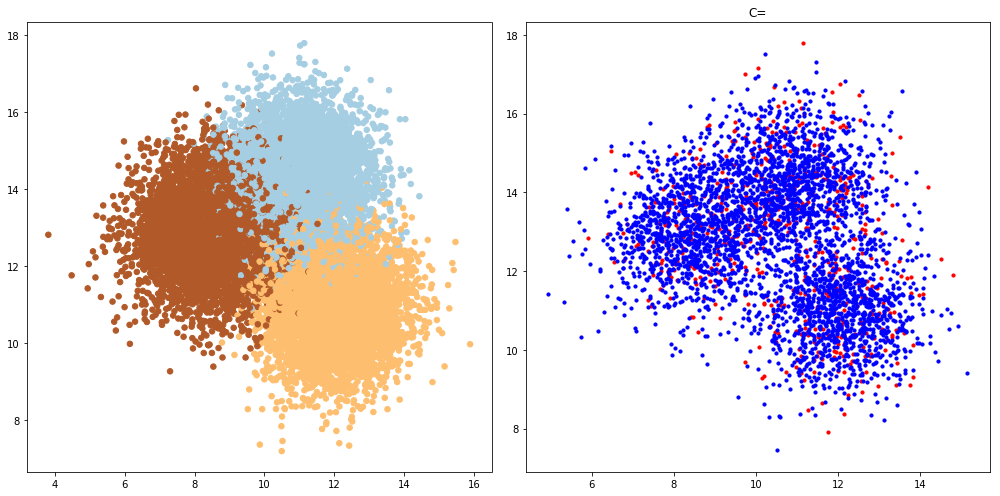

In [19]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)

plt.scatter(t_X[:, 0], t_X[:, 1], c=t_y, s=30, cmap=plt.cm.Paired)

plt.subplot(1, 2, 2)


plt.scatter(t_X[support_vector_indices, :][:, 0], t_X[support_vector_indices, :][:, 1], c=[1,0,0,1], s=10, cmap=plt.cm.Paired)
plt.scatter(t_X[not_support_vector_indices, :][:, 0], t_X[not_support_vector_indices, :][:, 1], c=[0,0,1,1], s=10, cmap=plt.cm.Paired)



#plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

#plt.scatter(v_X[:, 0], v_X[:, 1], c=v_y, s=30, cmap=plt.cm.Paired)

'''plt.scatter(t_X[indices, :][:, 0], t_X[indices, :][:, 1], s=100,
            linewidth=4, facecolors='none', edgecolors='#ff0000')'''


'''plt.scatter(v_X[mask][:, 0], v_X[mask][:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='#00ff00', c=preds[mask], cmap=plt.cm.Paired)'''

'''mistakes = np.array([[0,0,1,1] if preds[x] == v_y[x] else [0,0,0,1] for x in range(preds.shape[0])])
plt.scatter(v_X[filtered_mask][:, 0], v_X[filtered_mask][:, 1], s=100,
            linewidth=2, facecolors='none', edgecolors=mistakes[filtered_mask])
'''



plt.title("C=")

plt.tight_layout()
plt.show()

In [28]:
low_preds, low_mask, low_indices, low_not_support_vector_indices = plot_support_co_train(t_X, t_y, v_X, scaler=0.8, threshold=0.5)
np.mean(low_preds[mask] == v_y[mask])

preds, mask, indices, not_support_vector_indices = plot_support_co_train(t_X, t_y, v_X, scaler=0.8, threshold=0.98)
np.mean(preds[mask] == v_y[mask])

C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

{0: 0.8, 1: 0.8, 2: 0.8}
Prob mask a: 3930
Prob mask b: 3951
Mask length: 3806


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

{0: 0.8, 1: 0.8, 2: 0.8}
Prob mask a: 1830
Prob mask b: 840
Mask length: 840


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1.0

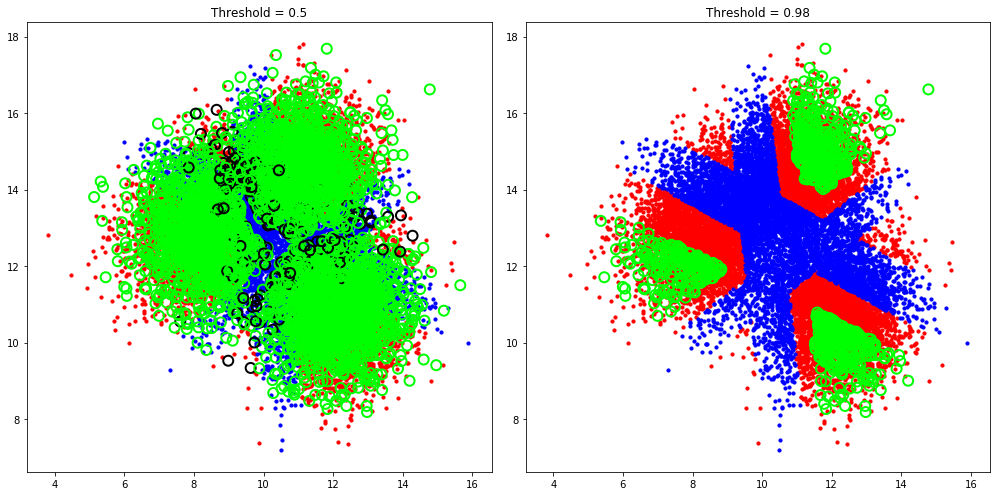

In [30]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)

#plt.scatter(v_X[:, 0], v_X[:, 1], c=v_y, s=30, cmap=plt.cm.Paired)

plt.title("Threshold = 0.5")

plt.scatter(t_X[low_not_support_vector_indices, :][:, 0], t_X[low_not_support_vector_indices, :][:, 1], c=[1,0,0,1], s=10, cmap=plt.cm.Paired)
plt.scatter(t_X[low_indices, :][:, 0], t_X[low_indices, :][:, 1], c=[0,0,1,1], s=10, cmap=plt.cm.Paired)

low_mistakes = np.array([[0,1,0,1] if low_preds[x] == v_y[x] else [0,0,0,1] for x in range(low_preds.shape[0])])
plt.scatter(v_X[low_mask][:, 0], v_X[low_mask][:, 1], s=100,
            linewidth=2, facecolors='none', edgecolors=low_mistakes[low_mask])



plt.subplot(1, 2, 2)

plt.title("Threshold = 0.98")

plt.scatter(t_X[not_support_vector_indices, :][:, 0], t_X[not_support_vector_indices, :][:, 1], c=[1,0,0,1], s=10, cmap=plt.cm.Paired)
plt.scatter(t_X[indices, :][:, 0], t_X[indices, :][:, 1], c=[0,0,1,1], s=10, cmap=plt.cm.Paired)



'''plt.scatter(t_X[indices, :][:, 0], t_X[indices, :][:, 1], s=30,
            linewidth=1, facecolors='none', edgecolors=[1,1,1,0.8], c=t_y[indices], cmap=plt.cm.Paired)

plt.scatter(t_X[not_support_vector_indices, :][:, 0], t_X[not_support_vector_indices, :][:, 1], s=30,
            linewidth=1, facecolors='none', edgecolors=[0,0,0,0.8], c=t_y[not_support_vector_indices], cmap=plt.cm.Paired)

plt.scatter(t_X[:, 0], t_X[:, 1], c=t_y, s=30, cmap=plt.cm.Paired)

plt.scatter(t_X[indices, :][:, 0], t_X[indices, :][:, 1], s=100,
            linewidth=4, facecolors='none', edgecolors='#ff0000')

plt.scatter(t_X[not_support_vector_indices, :][:, 0], t_X[not_support_vector_indices, :][:, 1], s=100,
            linewidth=4, facecolors='none', edgecolors='#ff0000')


plt.scatter(v_X[mask][:, 0], v_X[mask][:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='#00ff00', c=preds[mask], cmap=plt.cm.Paired)'''

mistakes = np.array([[0,1,0,1] if preds[x] == v_y[x] else [0,0,0,1] for x in range(preds.shape[0])])
plt.scatter(v_X[mask][:, 0], v_X[mask][:, 1], s=100,
            linewidth=2, facecolors='none', edgecolors=mistakes[mask])



plt.tight_layout()
plt.show()

In [11]:
below_X, above_X, below_y, above_y, mask, preds_below = plot_entropy_co_train(t_X, t_y, v_X, scaler=0.95, threshold=0.9)
np.mean(preds_below[mask] == v_y[mask])

C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

{0: 0.95, 1: 0.95, 2: 0.95}


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

Prob mask a: 1631
Prob mask b: 2640
Mask length: 1631


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9950950337216432

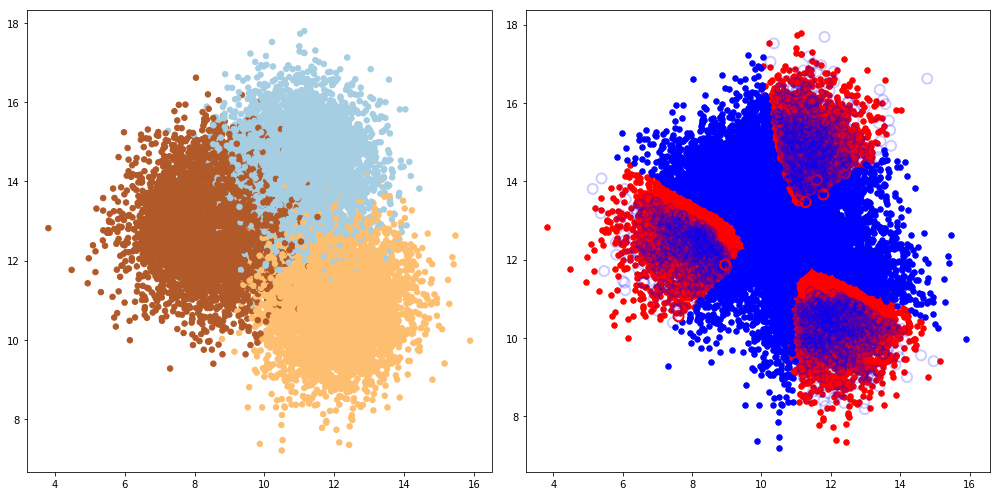

In [13]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)

plt.scatter(t_X[:, 0], t_X[:, 1], c=t_y, s=30, cmap=plt.cm.Paired)

plt.subplot(1, 2, 2)


plt.scatter(below_X[:, 0], below_X[:, 1], c=[1,0,0,1], s=30, cmap=plt.cm.Paired)
plt.scatter(above_X[:, 0], above_X[:, 1], c=[0,0,1,1], s=30, cmap=plt.cm.Paired)


'''plt.scatter(below_X[:, 0], below_X[:, 1], s=30,
            linewidth=1, facecolors='none', edgecolors=[0,0,0,0.8], c=below_y, cmap=plt.cm.Paired)

plt.scatter(above_X[:, 0], above_X[:, 1], s=30,
            linewidth=1, facecolors='none', edgecolors=[1,1,1,0.8], c=above_y, cmap=plt.cm.Paired)'''

mistakes = np.array([[0,0,1,0.2] if preds_below[x] == v_y[x] else [1,0,0,1] for x in range(preds_below.shape[0])])
plt.scatter(v_X[mask][:, 0], v_X[mask][:, 1], s=100,
            linewidth=2, facecolors='none', edgecolors=mistakes[mask])

plt.tight_layout()
plt.show()

In [ ]:
preds, mask = get_single_train(t_X, t_y, v_X, scaler=0.8)
print(mask.sum())
np.mean(preds[mask] == v_y[mask])

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 1, 1)

plt.scatter(v_X[:, 0], v_X[:, 1], c=v_y, s=30, cmap=plt.cm.Paired)



'''plt.scatter(v_X[mask][:, 0], v_X[mask][:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors=mistakes[mask], c=preds[mask], cmap=plt.cm.Paired)'''

mistakes = np.array([[0,0,0,0] if preds[x] == v_y[x] else [0,0,0,1] for x in range(preds.shape[0])])
plt.scatter(v_X[mask][:, 0], v_X[mask][:, 1], s=100,
            linewidth=2, facecolors='none', edgecolors=mistakes[mask])

plt.title("C=")

plt.tight_layout()
plt.show()

In [ ]:
preds, mask, train_a_X, train_b_X, train_a_y, train_b_y = plot_random_co_train(t_X, t_y, v_X, scaler=0.988, threshold=0.9)
np.mean(preds[mask] == v_y[mask])

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)

plt.scatter(t_X[:, 0], t_X[:, 1], c=t_y, s=30, cmap=plt.cm.Paired)

plt.subplot(1, 2, 2)


plt.scatter(train_a_X[:, 0], train_a_X[:, 1], c=[1,0,0,1], s=10, cmap=plt.cm.Paired)
plt.scatter(train_b_X[:, 0], train_b_X[:, 1], c=[0,0,1,1], s=10, cmap=plt.cm.Paired)


'''plt.scatter(train_a_X[:, 0], train_a_X[:, 1], s=30,
            linewidth=1, facecolors='none', edgecolors=[0,0,0,0.8], c=train_a_y, cmap=plt.cm.Paired)

plt.scatter(train_b_X[:, 0], train_b_X[:, 1], s=30,
            linewidth=1, facecolors='none', edgecolors=[1,1,1,0.8], c=train_b_y, cmap=plt.cm.Paired)

mistakes = np.array([[0,0,1,0.2] if preds[x] == v_y[x] else [1,0,0,1] for x in range(preds.shape[0])])
plt.scatter(v_X[mask][:, 0], v_X[mask][:, 1], s=100,
            linewidth=2, facecolors='none', edgecolors=mistakes[mask])'''


plt.tight_layout()
plt.show()